In [12]:
%matplotlib inline
from Chapter5.DistanceMetrics import InstanceDistanceMetrics
from Chapter5.DistanceMetrics import PersonDistanceMetricsNoOrdering
from Chapter5.DistanceMetrics import PersonDistanceMetricsOrdering
from Chapter5.Clustering import NonHierarchicalClustering
from Chapter5.Clustering import HierarchicalClustering
from util.VisualizeDataset import VisualizeDataset
from IPython.display import display
from scipy.cluster.hierarchy import dendrogram

import util.util as util
import sys
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os

plt.rcParams['figure.dpi'] = 250


In [52]:
# best k-values tested
K_KMEAN_ACC = 4
K_KMEAN_GRAV = 4
K_KMEAN_LIN = 2
K_KMEAN_GYR = 2

##
K_KMED_LIN = 2 #until now (?) silhouette = 0.7024984007260902



In [2]:
def plot_xy(x, y, method='plot', xlabel=None, ylabel=None, xlim=None, ylim=None, names=None,
            line_styles=None, loc=None, title=None):
    for input in x, y:
        if not hasattr(input[0], '__iter__'):
            raise TypeError('x/y should be given as a list of lists of coordinates')

    plot_method = getattr(plt, method)
    for i, (x_line, y_line) in enumerate(zip(x, y)):

        plot_method(x_line, y_line, line_styles[i]) if line_styles is not None else plt.plot(x_line, y_line)

        if xlabel is not None: plt.xlabel(xlabel)
        if ylabel is not None: plt.ylabel(ylabel)
        if xlim is not None: plt.xlim(xlim)
        if ylim is not None: plt.ylim(ylim)
        if title is not None: plt.title(title)
        if names is not None: plt.legend(names)


    plt.figure()


In [3]:
def plot_clusters_3d(data_table, data_cols, cluster_col, label_cols,title=''):

    color_index = 0
    point_displays = ['+', 'v', '^', '<','>','d', 'o', 's','1']
    # Determine the number of clusters:
    
    clusters = data_table[cluster_col].unique()
    
    labels = []

    # Get the possible labels, assuming 1 or more label columns with binary values.
    for i in range(0, len(label_cols)):
        labels.extend([name for name in list(data_table.columns) if label_cols[i] == name[0:len(label_cols[i])]])
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    handles = []

    # Plot clusters individually with a certain color.
    for cluster in clusters:
        marker_index = 0
        # And make sure the points of a label receive the right marker type.
        for label in labels:
            rows = data_table.loc[(data_table[cluster_col] == cluster) & (data_table[label] > 0)]
            # Now we come to the assumption that there are three data_cols specified:
            if not len(data_cols) == 3:
                return
            # plot_color = colors[color_index%len(colors)]
            plot_color = [plt.get_cmap('Set2')(float(cluster) / len(clusters))]
            plot_marker = point_displays[marker_index%len(point_displays)]
            pt = ax.scatter(rows[data_cols[0]], rows[data_cols[1]], rows[data_cols[2]], c=plot_color, marker=plot_marker, s=4)
            if color_index == 0:
                handles.append(pt)
            ax.set_xlabel(data_cols[0])
            ax.set_ylabel(data_cols[1])
            ax.set_zlabel(data_cols[2])
            marker_index += 1
        color_index += 1

    plt.legend(handles, labels, fontsize='xx-small', numpoints=1)
    if title is not None: plt.title(title)
    # plt.show()
    plt.figure()

In [5]:
def plot_dendrogram(dataset, linkage):
    sys.setrecursionlimit(40000)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('time points')
    plt.ylabel('distance')
    times = dataset.index.strftime('%H:%M:%S')
    #dendrogram(linkage,truncate_mode='lastp',p=10, show_leaf_counts=True, leaf_rotation=90.,leaf_font_size=12.,show_contracted=True, labels=times)
    dendrogram(linkage,truncate_mode='lastp',p=16, show_leaf_counts=True, leaf_rotation=45.,leaf_font_size=8.,show_contracted=True, labels=times)
    
    plt.figure()

In [4]:
def plot_silhouette(data_table, cluster_col, silhouette_col):
    # Taken from the examples of scikit learn
    #(http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

    clusters = data_table[cluster_col].unique()

    fig, ax1 = plt.subplots(1, 1)
    ax1.set_xlim([-0.1, 1])
    #ax1.set_ylim([0, len(data_table.index) + (len(clusters) + 1) * 10])
    y_lower = 10
    for i in range(0, len(clusters)):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        rows = data_table.mask(data_table[cluster_col] != clusters[i])
        ith_cluster_silhouette_values = np.array(rows[silhouette_col])
        ith_cluster_silhouette_values.sort()

        size_cluster_i = len(rows.index)
        y_upper = y_lower + size_cluster_i

        color = [plt.get_cmap('Set2')(float(i) / len(clusters))]
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.05 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=data_table[silhouette_col].mean(), color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.figure()

In [5]:
# dataset = pd.read_csv("./A3_dataset/COMBINED_ch4_result.csv")
dataset = pd.read_csv("./A3_dataset/COMBINED_ch5_result.csv") # cluster until now

clusteringNH = NonHierarchicalClustering()
clusteringH = HierarchicalClustering()

In [6]:
dataset.columns

Index(['Unnamed: 0', 'acc_x', 'acc_y', 'acc_z', 'grav_x', 'grav_y', 'grav_z',
       'lin_x', 'lin_y', 'lin_z', 'gyr_x', 'gyr_y', 'gyr_z',
       'time_since_start', 'timestamp_date', 'timestamp_ms', 'label-jogging',
       'label-cycling', 'label-football', 'label-jumprope', 'label-pushups',
       'label-sitting', 'label-swimming', 'label-tennis', 'label-walking',
       'lin_x_max_freq_ws20', 'lin_y_max_freq_ws20', 'lin_z_max_freq_ws20',
       'lin_x_max_freq_ws40', 'lin_y_max_freq_ws40', 'lin_z_max_freq_ws40',
       'cluster_grav', 'silhouette_grav', 'cluster_acc', 'silhouette_acc',
       'cluster_lin', 'silhouette_lin', 'cluster_gyr', 'silhouette_gyr'],
      dtype='object')

### K-MEANS ACCELERATION ----------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Let us look at k-means first.
plt.rcParams['figure.figsize'] = [6, 5]
k_values = range(2, 10)
silhouette_values = []

# Do some initial runs to determine the right number for k
print('===== kmeans clustering =====')
for k in k_values:
    
    dataset = clusteringNH.k_means_over_instances(copy.deepcopy(dataset), ['acc_x', 'acc_y', 'acc_z'], k, 'default', 20, 10)
    silhouette_score = dataset['silhouette'].mean()
    print(f'k = {k} \t silhouette = {silhouette_score}')
    silhouette_values.append(silhouette_score)

k_kmean_acc = k_values[np.argmax(silhouette_values)]
print('Highest K-Means silhouette score: k = ',k_kmean_acc)
# plot_xy(x=[k_values], y=[silhouette_values], xlabel='k', ylabel='silhouette score', ylim=[0, 1], line_styles=['b-'],title= 'Silhouette scores for different k-values ')

In [59]:
dataset = clusteringNH.k_means_over_instances(dataset, ['acc_x', 'acc_y', 'acc_z'], K_KMEAN_ACC, 'default', 20, 10,cluster_name="_acc")

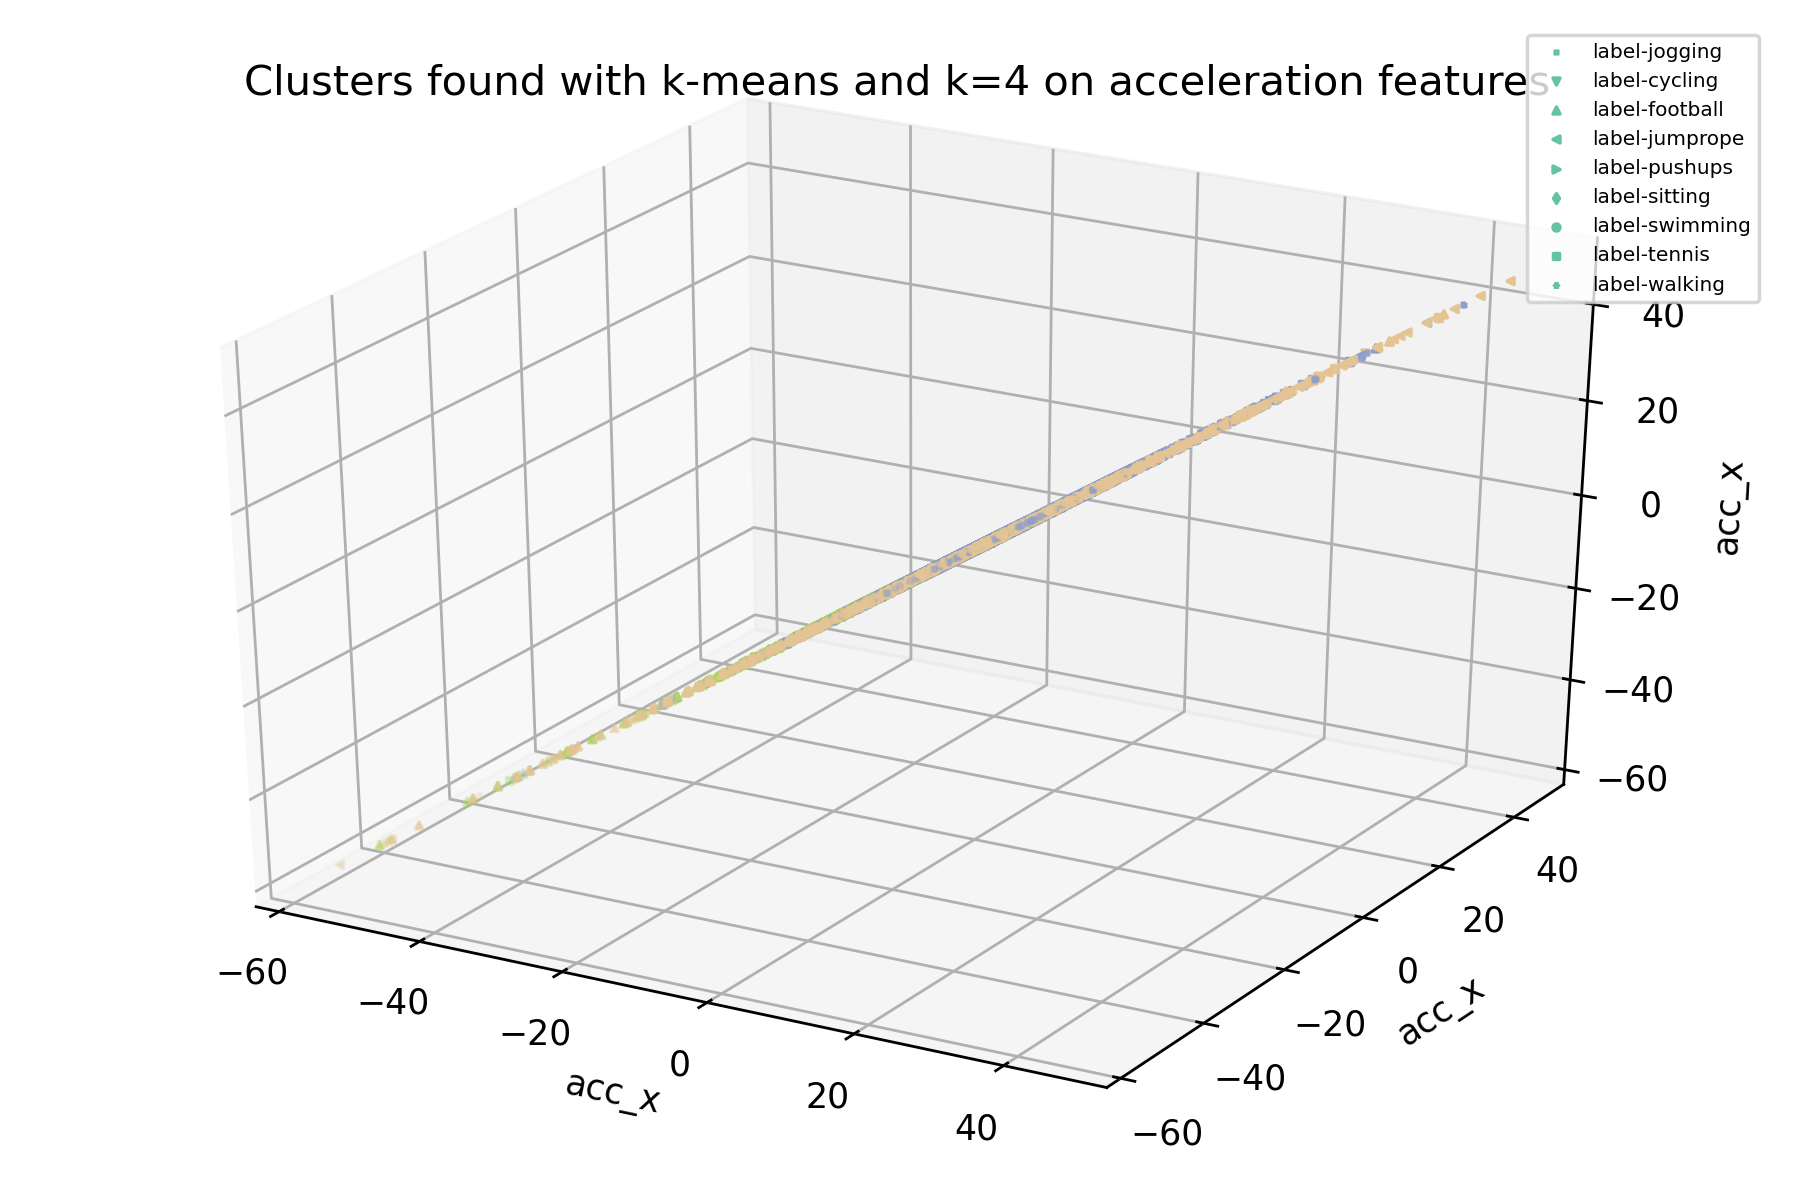

<Figure size 2250x1500 with 0 Axes>

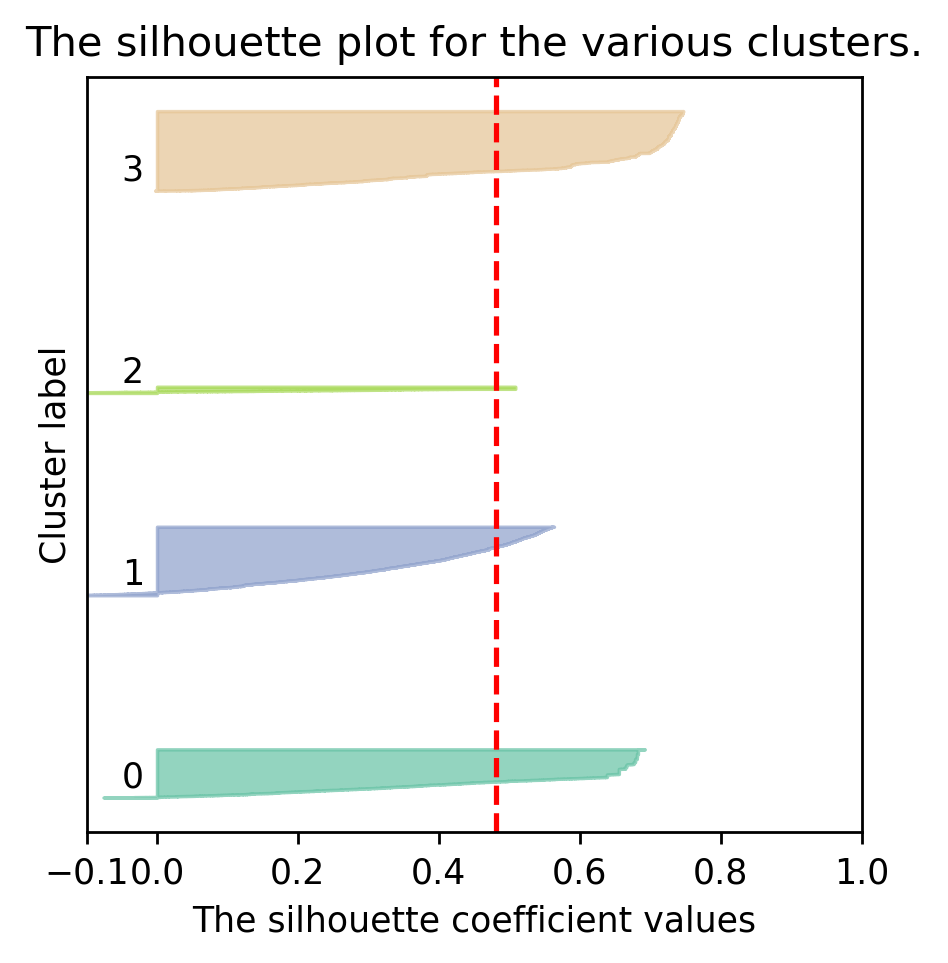

<Figure size 1000x1000 with 0 Axes>

In [63]:
# PLOT K-MEAN CLUSTER FOR ACCELERATION FEATURES WITH K = 4 
plt.rcParams['figure.figsize'] = [9,6]
plot_clusters_3d(copy.deepcopy(dataset), ['acc_x', 'acc_x', 'acc_x'], 'cluster_acc', ['label-'],title='Clusters found with k-means and k=4 on acceleration features')
plt.rcParams['figure.figsize'] = [4,4]
plot_silhouette(dataset, 'cluster_acc', 'silhouette_acc')

### K-MEANS GRAVITY ----------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [8]:
aux = copy.deepcopy(dataset)

In [ ]:
# Let us look at k-means first.
k_values = range(2, 10)
silhouette_values = []

# Do some initial runs to determine the right number for k

print('===== kmeans clustering =====')
for k in k_values:
    
    aux = clusteringNH.k_means_over_instances(copy.deepcopy(dataset), ['grav_x', 'grav_y', 'grav_z'], k, 'default', 20, 10,cluster_name='_grav')
    silhouette_score = aux['silhouette_grav'].mean()
    print(f'k = {k} \t silhouette = {silhouette_score}')
    silhouette_values.append(silhouette_score)

k_kmean_grav = k_values[np.argmax(silhouette_values)]
print('Highest K-Means silhouette score: k = ',k_kmean_grav)
# plot_xy(x=[k_values], y=[silhouette_values], xlabel='k', ylabel='silhouette score', ylim=[0, 1], line_styles=['b-'],title= 'Silhouette scores for different k-values ')


dataset = clusteringNH.k_means_over_instances( dataset, ['grav_x', 'grav_y', 'grav_z'], k_kmean_grav, 'default', 20, 10,cluster_name='_grav')

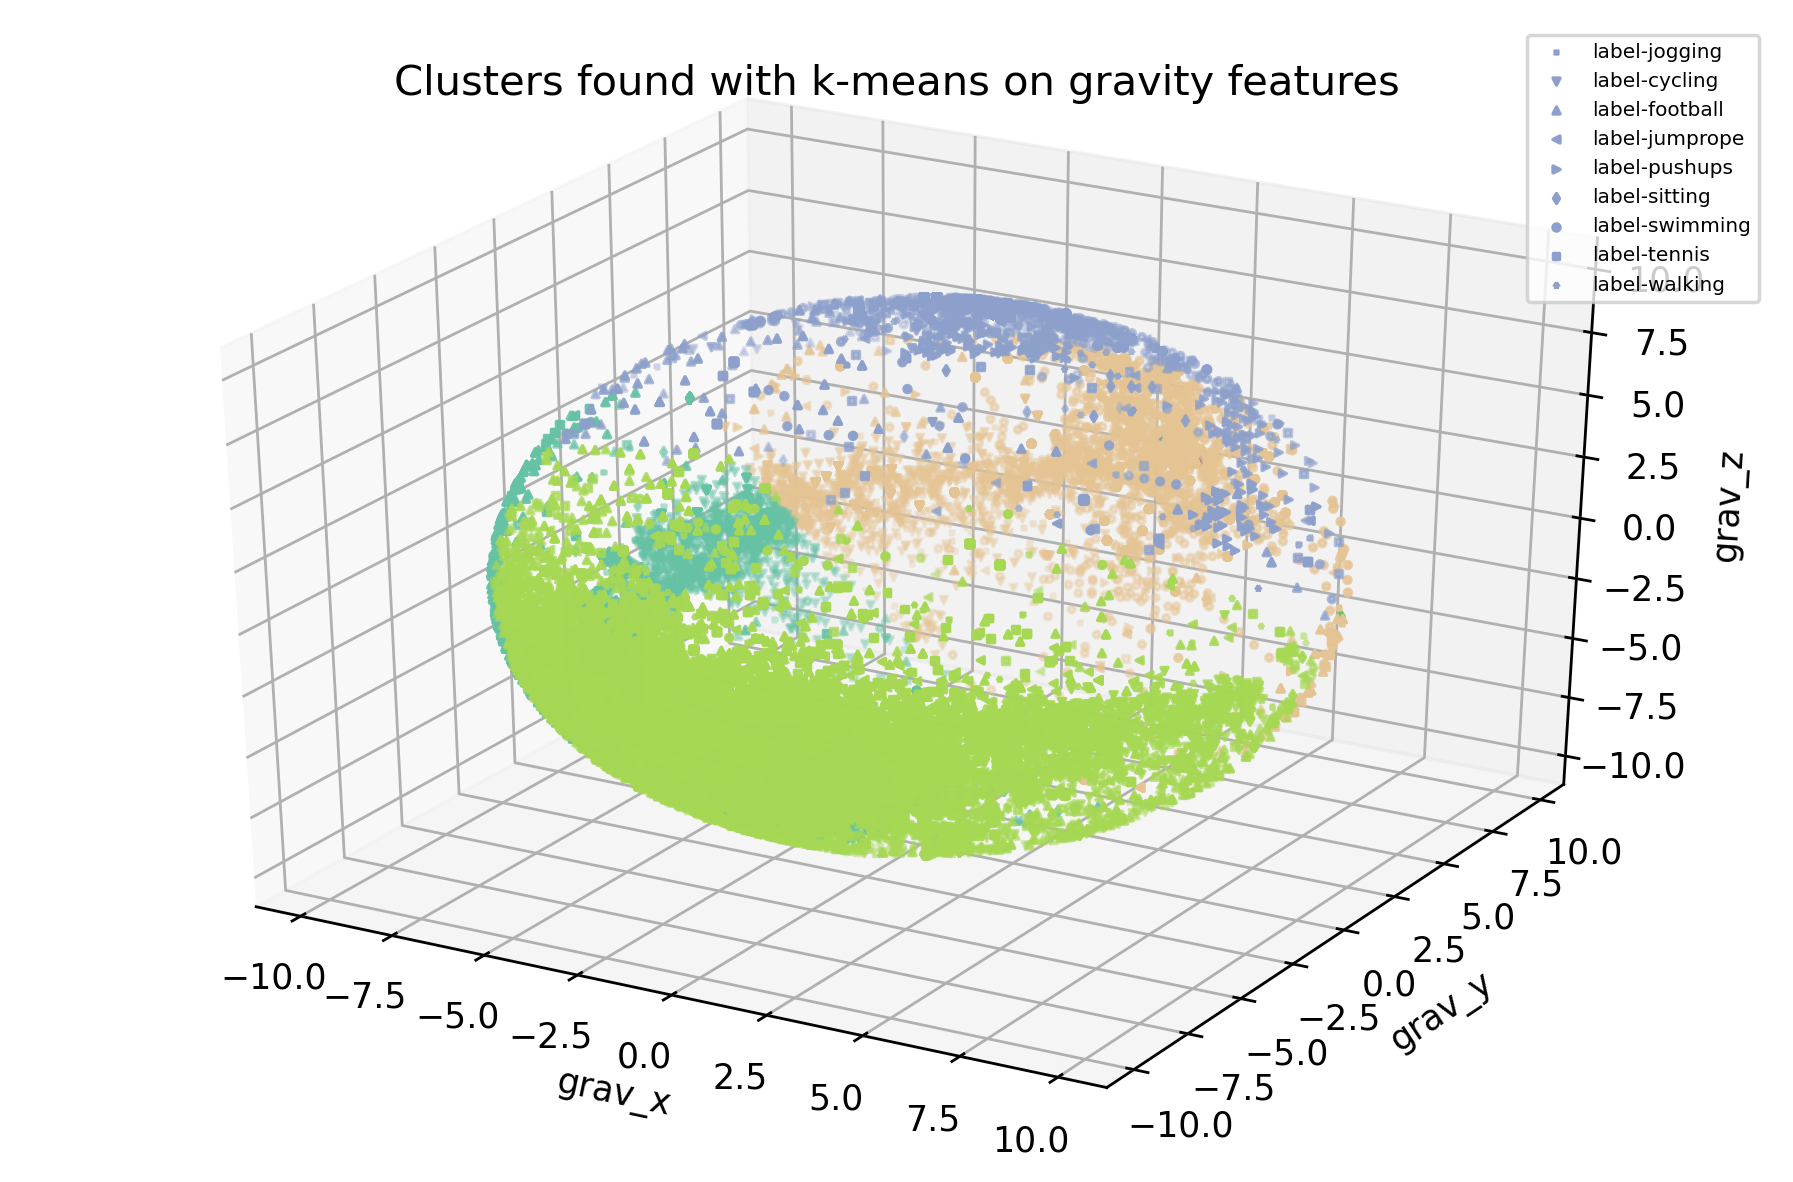

<Figure size 2250x1500 with 0 Axes>

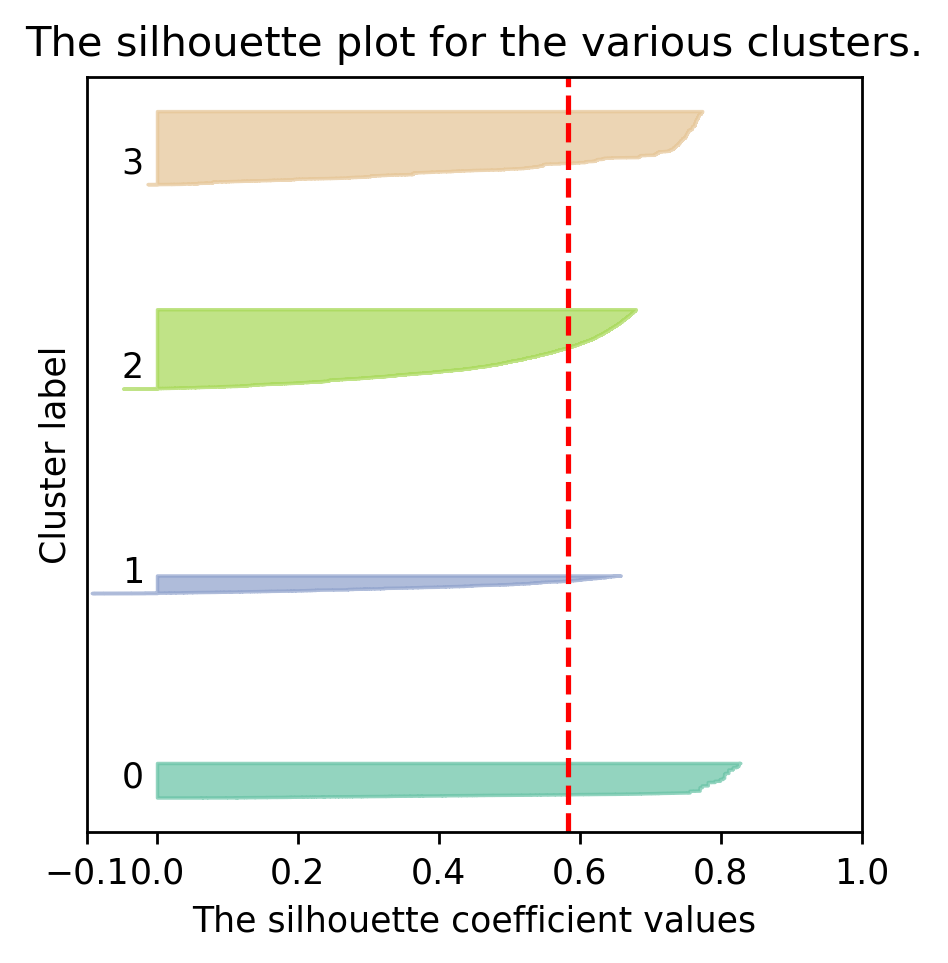

<Figure size 1000x1000 with 0 Axes>

In [66]:
plt.rcParams['figure.figsize'] = [9, 6]
plot_clusters_3d(dataset, ['grav_x', 'grav_y', 'grav_z'], 'cluster_grav', ['label'], title='Clusters found with k-means on gravity features')
plt.rcParams['figure.figsize'] = [4,4]
plot_silhouette(dataset, 'cluster_grav', 'silhouette_grav')

### K-MEANS LINEAR ACCELERATION ----------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [68]:
# Let us look at k-means first.
k_values = range(2, 10)
silhouette_values = []

# Do some initial runs to determine the right number for k

print('===== kmeans clustering =====')
for k in k_values:
    
    aux = clusteringNH.k_means_over_instances(copy.deepcopy(dataset), ['lin_x', 'lin_y', 'lin_z'], k, 'default', 20, 10,cluster_name='_lin')
    silhouette_score = aux['silhouette_lin'].mean()
    print(f'k = {k} \t silhouette = {silhouette_score}')
    silhouette_values.append(silhouette_score)

k_kmean_linear = k_values[np.argmax(silhouette_values)]
print('Highest K-Means silhouette score: k = ',k_kmean_linear)
# plot_xy(x=[k_values], y=[silhouette_values], xlabel='k', ylabel='silhouette score', ylim=[0, 1], line_styles=['b-'],title= 'Silhouette scores for different k-values ')


dataset = clusteringNH.k_means_over_instances( dataset, ['lin_x', 'lin_y', 'lin_z'], K_KMEAN_LIN, 'default', 20, 10,cluster_name='_lin')

===== kmeans clustering =====
k = 2 	 silhouette = 0.8453382933318055
k = 3 	 silhouette = 0.7425516388105099
k = 4 	 silhouette = 0.7164990233416237
k = 5 	 silhouette = 0.7165897202460343
k = 6 	 silhouette = 0.7144497917613327
k = 7 	 silhouette = 0.7084263447489583
k = 8 	 silhouette = 0.7085349632045379
k = 9 	 silhouette = 0.6936049083938424
Highest K-Means silhouette score: k =  2


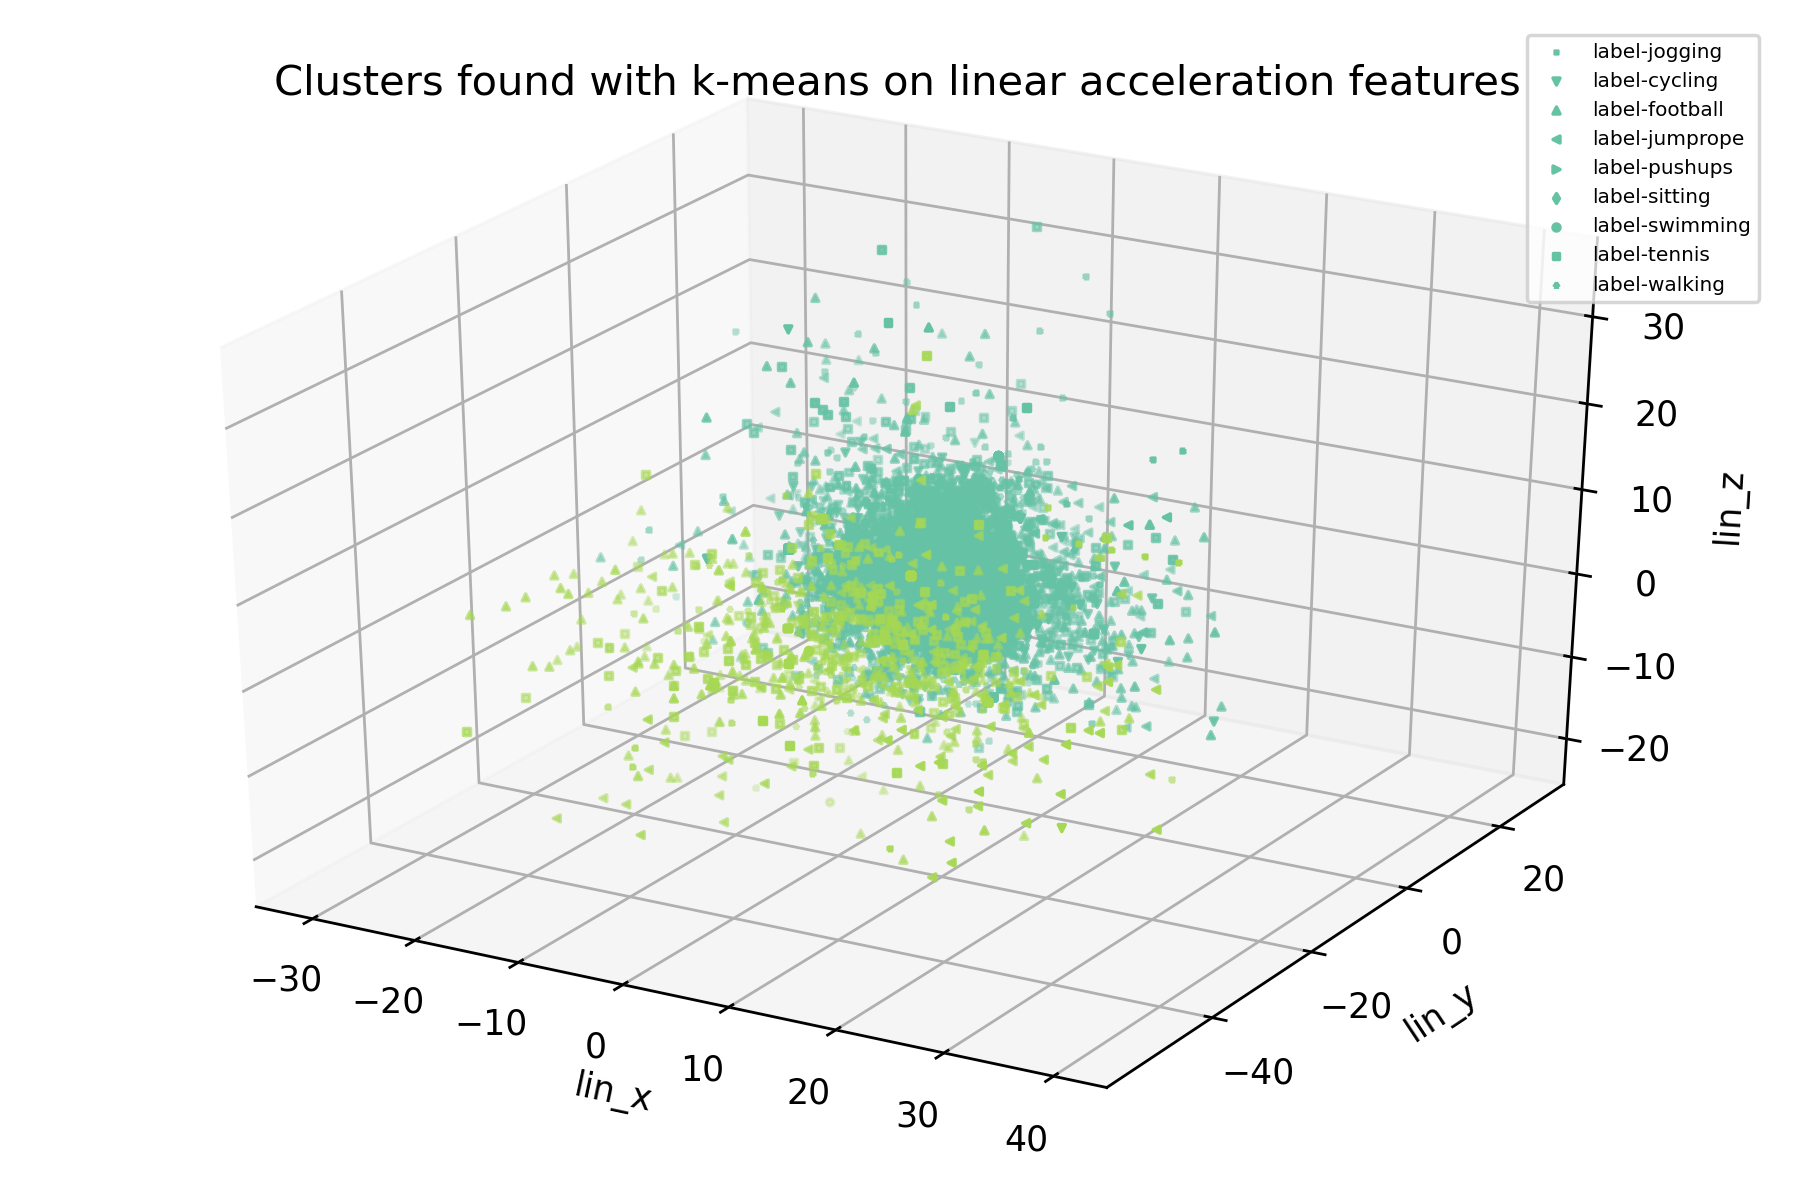

<Figure size 2250x1500 with 0 Axes>

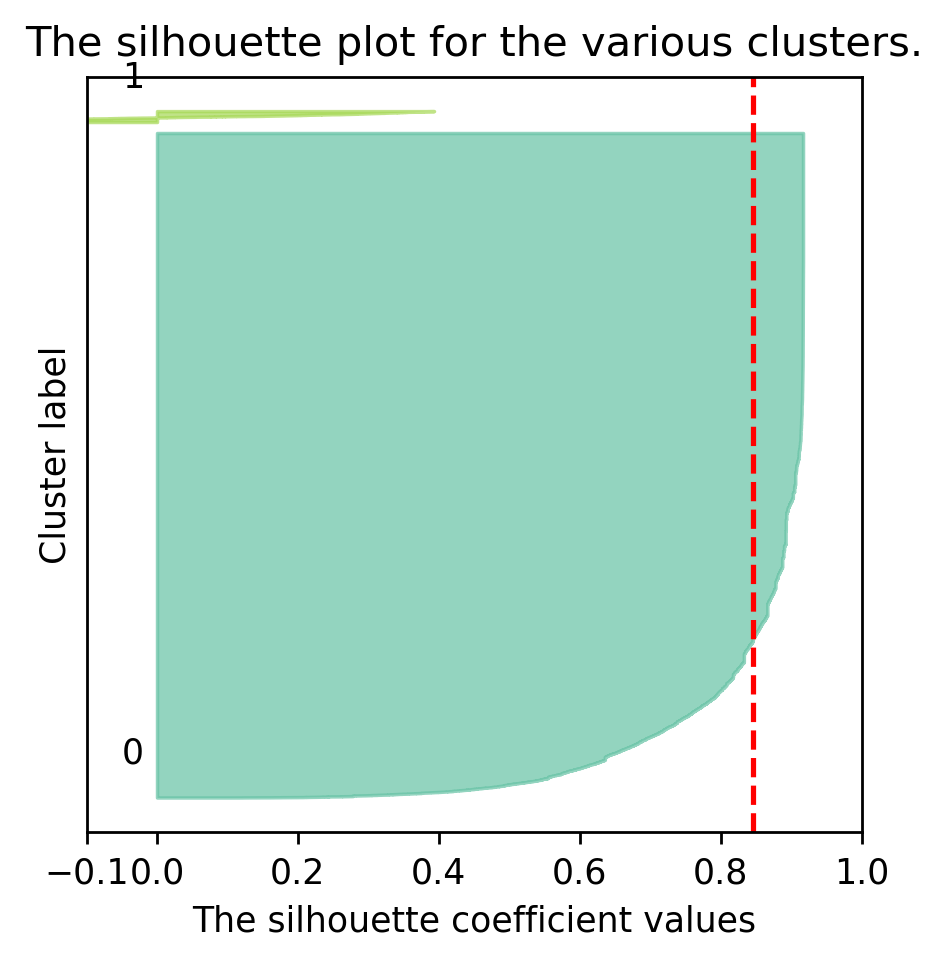

<Figure size 1000x1000 with 0 Axes>

In [70]:
plt.rcParams['figure.figsize'] = [9, 6]
plot_clusters_3d(dataset, ['lin_x', 'lin_y', 'lin_z'], 'cluster_lin', ['label'], title='Clusters found with k-means on linear acceleration features')
plt.rcParams['figure.figsize'] = [4,4]
plot_silhouette(dataset, 'cluster_lin', 'silhouette_lin')

## K-MEANS GYROSCOPE -----------------------------------------------------------------------------------------------------------------


In [76]:
# Let us look at k-means first.
k_values = range(2, 10)
silhouette_values = []

# Do some initial runs to determine the right number for k

print('===== kmeans clustering =====')
for k in k_values:
    
    aux = clusteringNH.k_means_over_instances(copy.deepcopy(dataset), ['gyr_x', 'gyr_y', 'gyr_z'], k, 'default', 20, 10,cluster_name='_gyr')
    silhouette_score = aux['silhouette_gyr'].mean()
    print(f'k = {k} \t silhouette = {silhouette_score}')
    silhouette_values.append(silhouette_score)

k_kmean_gyr = k_values[np.argmax(silhouette_values)]
print('Highest K-Means silhouette score: k = ',k_kmean_gyr)

dataset = clusteringNH.k_means_over_instances( dataset, ['gyr_x', 'gyr_y', 'gyr_z'], K_KMEAN_GYR, 'default', 20, 10,cluster_name='_gyr')

===== kmeans clustering =====
k = 2 	 silhouette = 0.5953483897597303
k = 3 	 silhouette = 0.5688766987072061
k = 4 	 silhouette = 0.5495019475764793
k = 5 	 silhouette = 0.512244147999996
k = 6 	 silhouette = 0.5242684397297019
k = 7 	 silhouette = 0.5297098482864186
k = 8 	 silhouette = 0.5359275394697778
k = 9 	 silhouette = 0.5451212268634807
Highest K-Means silhouette score: k =  2


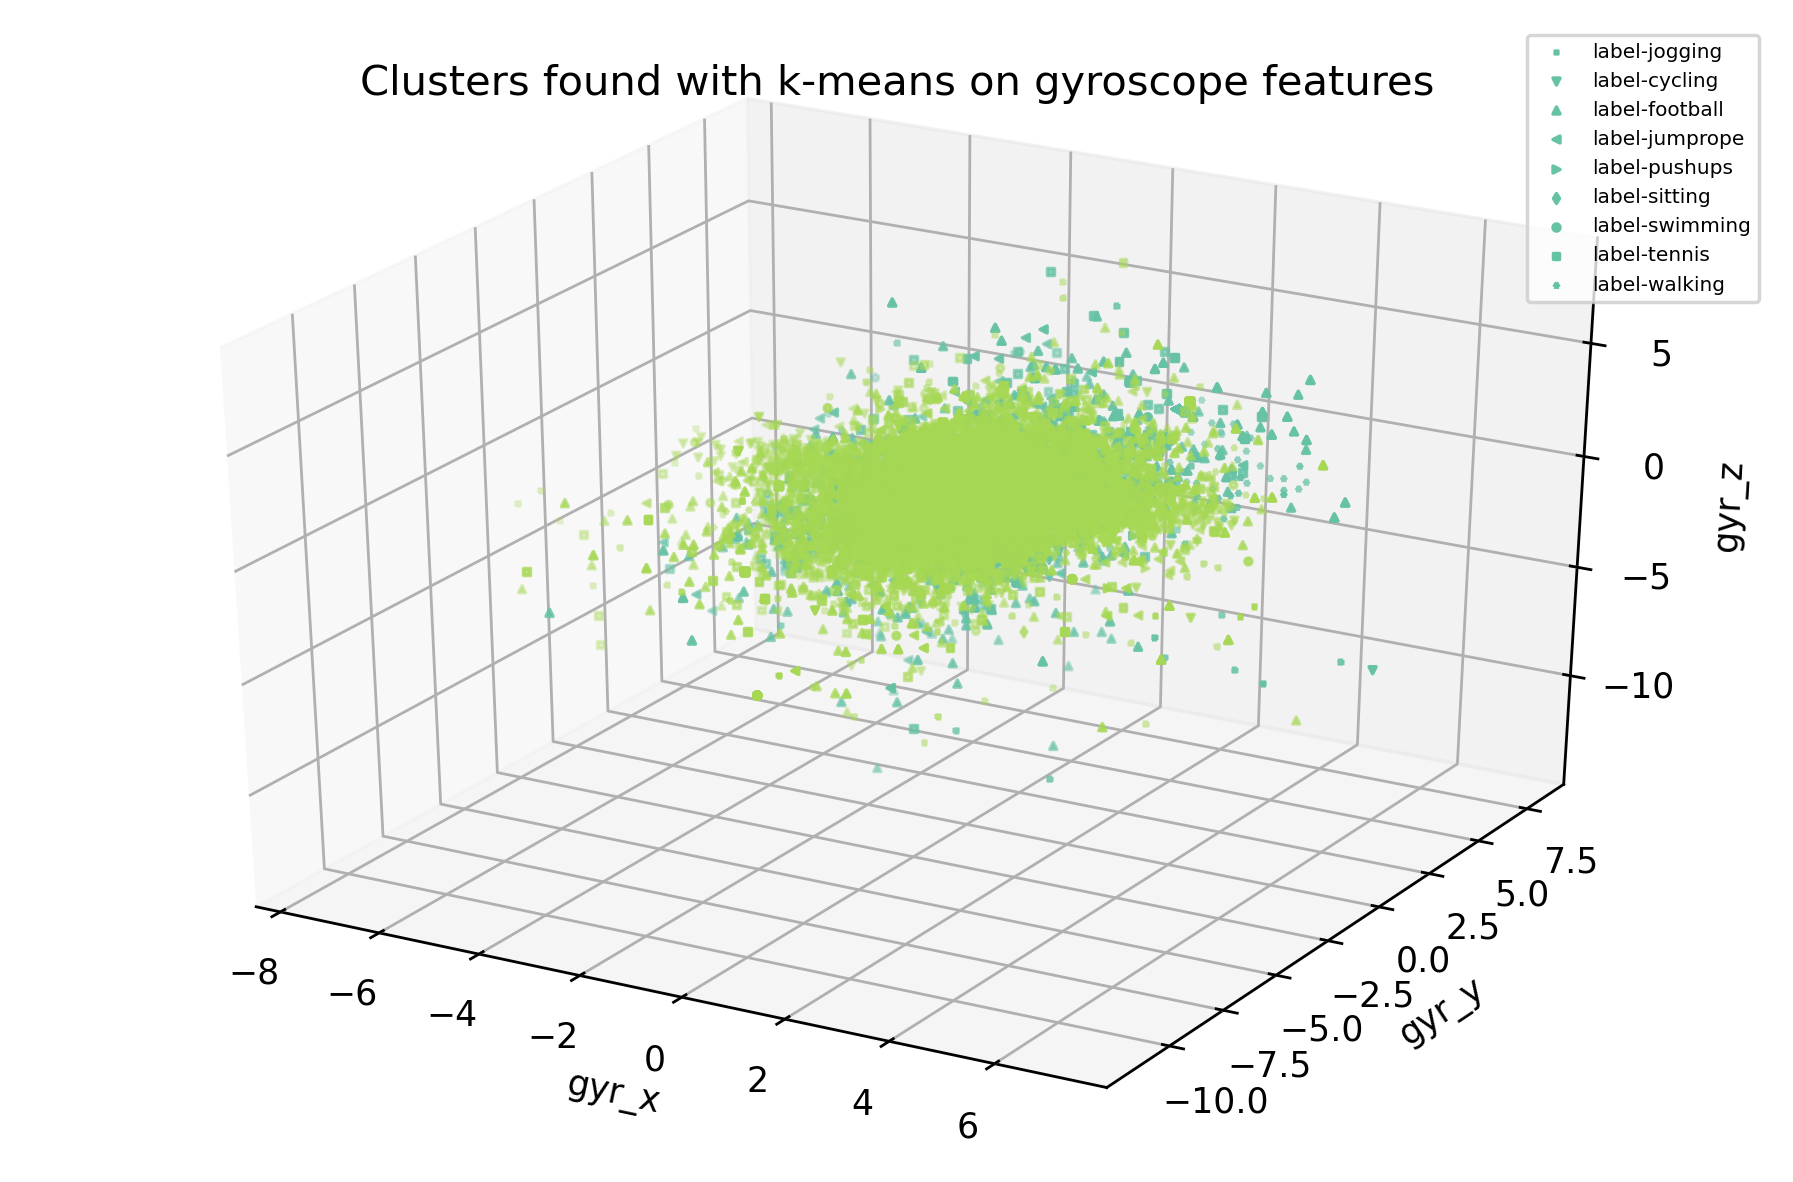

<Figure size 2250x1500 with 0 Axes>

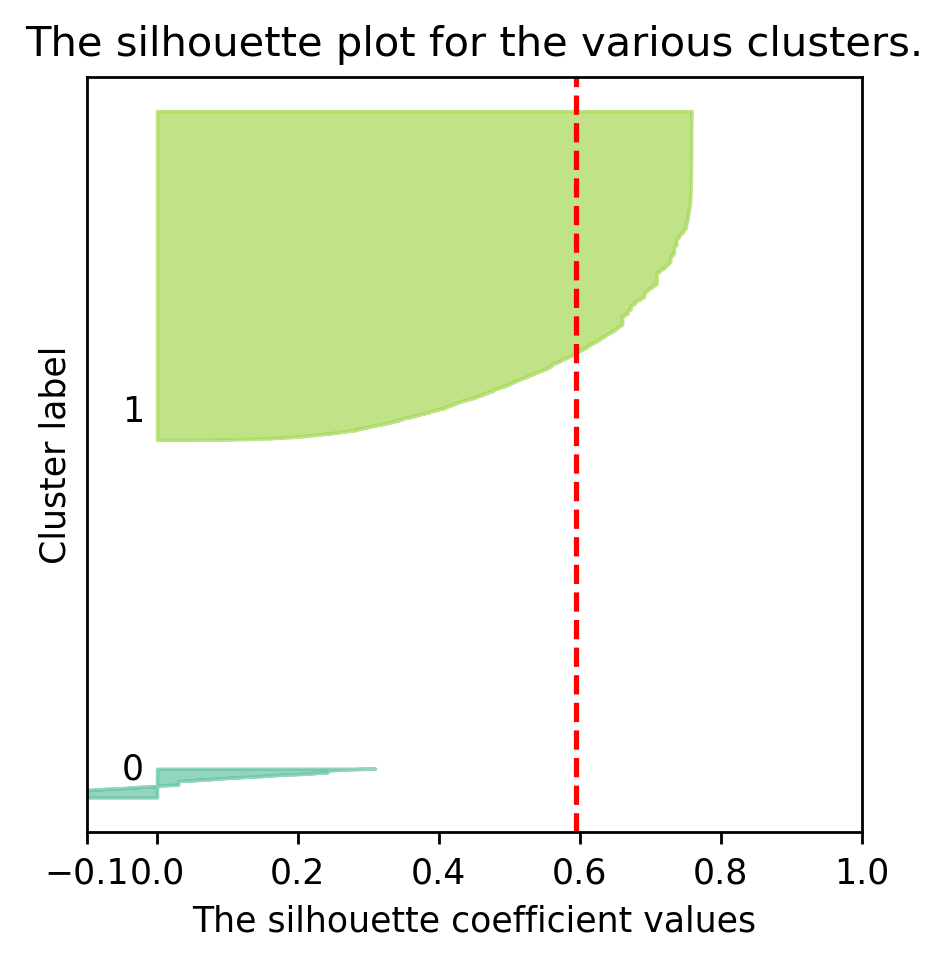

<Figure size 1000x1000 with 0 Axes>

In [77]:
plt.rcParams['figure.figsize'] = [9, 6]
plot_clusters_3d(dataset, ['gyr_x', 'gyr_y', 'gyr_z'], 'cluster_gyr', ['label'], title='Clusters found with k-means on gyroscope features')
plt.rcParams['figure.figsize'] = [4,4]
plot_silhouette(dataset, 'cluster_gyr', 'silhouette_gyr')

In [71]:
dataset.columns

Index(['Unnamed: 0', 'acc_x', 'acc_y', 'acc_z', 'grav_x', 'grav_y', 'grav_z',
       'lin_x', 'lin_y', 'lin_z', 'gyr_x', 'gyr_y', 'gyr_z',
       'time_since_start', 'timestamp_date', 'timestamp_ms', 'label-jogging',
       'label-cycling', 'label-football', 'label-jumprope', 'label-pushups',
       'label-sitting', 'label-swimming', 'label-tennis', 'label-walking',
       'lin_x_max_freq_ws20', 'lin_y_max_freq_ws20', 'lin_z_max_freq_ws20',
       'lin_x_max_freq_ws40', 'lin_y_max_freq_ws40', 'lin_z_max_freq_ws40',
       'cluster_grav', 'silhouette_grav', 'cluster_acc', 'silhouette_acc',
       'cluster_lin', 'silhouette_lin'],
      dtype='object')

In [58]:
dataset = dataset[dataset.columns.drop('cluster')]

In [78]:
dataset.to_csv("./A3_dataset/COMBINED_ch5_result.csv", index=False)

## K-MEDOIDS ACCELERATION -------------------------------------------------------------------------------------------------

In [13]:
# Do some initial runs to determine the right number for k
k_values = range(2, 10)
silhouette_values = []

for k in k_values:
    print(f'k = {k}')
    aux = clusteringNH.k_medoids_over_instances(copy.deepcopy(dataset), ['acc_x', 'acc_y', 'acc_z'], k, 'default', 20, n_inits=10)
    silhouette_score = aux['silhouette'].mean()
    print(f'silhouette = {silhouette_score}')
    silhouette_values.append(silhouette_score)

k_kmed_acc = k_values[np.argmax(silhouette_values)]
print(f'Highest K-Medoids silhouette score: k = {k_kmed_acc}')

dataset = clusteringNH.k_means_over_instances(dataset, ['acc_x', 'acc_y', 'acc_z'], k_kmed_acc, 'default', 20, 10,cluster_name='_kmed_acc')


k = 2


KeyboardInterrupt: 

## K-MEDOIDS ACCELERATION -------------------------------------------------------------------------------------------------

In [11]:
dataset[['lin_x', 'lin_y', 'lin_z']].values

array([[ 2.0062, -0.4442, -2.373 ],
       [ 1.2018,  2.6037,  9.4019],
       [22.8759, -0.5101, 20.9578],
       ...,
       [ 0.8653, -0.9992,  1.2886],
       [ 1.3046,  0.133 , -0.4811],
       [ 1.2737, -0.2596,  0.6452]])

In [14]:
# Do some initial runs to determine the right number for k
k_values = range(2, 10)
silhouette_values = []

for k in k_values:
    print(f'k = {k}')
    aux = clusteringNH.k_medoids_over_instances(copy.deepcopy(dataset), ['lin_x', 'lin_y', 'lin_z'], k, 'default', 20, n_inits=10)
    silhouette_score = aux['silhouette'].mean()
    print(f'silhouette = {silhouette_score}')
    silhouette_values.append(silhouette_score)

k_kmed_lin = k_values[np.argmax(silhouette_values)]
print(f'Highest K-Medoids silhouette score: k = {k_kmed_lin}')

dataset = clusteringNH.k_means_over_instances(dataset, ['lin_x', 'lin_y', 'lin_z'], k_kmed_lin, 'default', 20, 10,cluster_name='_kmed_lin')

k = 2
silhouette = 0.7024984007260902
k = 3


ValueError: attempt to get argmin of an empty sequence

## HIERARCHICAL


In [ ]:

k_values = range(2, 10)
silhouette_values = []

# Do some initial runs to determine the right number for the maximum number of clusters.

print('===== agglomerative clustering =====')
for k in k_values:
    print(f'k = {k}')
    dataset, l = clusteringH.agglomerative_over_instances(copy.deepcopy(dataset), ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z'], k, 'euclidean', use_prev_linkage=True, link_function='ward')
    silhouette_score = dataset['silhouette'].mean()
    print(f'silhouette = {silhouette_score}')
    silhouette_values.append(silhouette_score)
    
    if k == k_values[0]:
        plt.rcParams['figure.figsize'] = [10, 8]
        plot_dendrogram(dataset, l)


plt.rcParams['figure.figsize'] = [12, 10]
plot_xy(x=[k_values], y=[silhouette_values], xlabel='k', ylabel='silhouette score',
                ylim=[0, 1], line_styles=['b-'])



In [ ]:
dataset, l = clusteringH.agglomerative_over_instances(copy.deepcopy(dataset), ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z'], 5, 'euclidean', use_prev_linkage=True, link_function='ward')
util.print_latex_statistics_clusters(dataset, 'cluster', ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z'], 'label')
plot_silhouette(dataset, 'cluster', 'silhouette')